In [1]:
import sys
import math
import time
import random
sys.path.append("/github/meta_learning/np_variants/")

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (7.2, 4.8)

In [2]:
dtype = torch.double
device = torch.device("cuda")

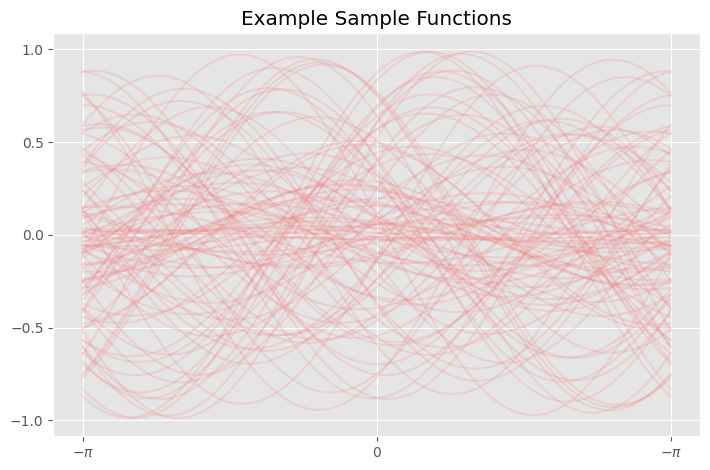

In [3]:
from data.functions_1d import SineFunc

func = SineFunc()
_, _, (amplitude, shift) = func.sample_data(num_tasks=100, num_samples=20)

for i in range(100):
    x = torch.linspace(-math.pi, math.pi, 200)
    y = amplitude[i] * torch.sin((x - shift[i]))
    plt.plot(x.detach().numpy(), y.detach().numpy(), color="lightcoral", alpha=0.2)

plt.xticks(ticks=[-math.pi, 0, math.pi], labels=[r"$-\pi$", r"0", r"$-\pi$"])
plt.yticks(ticks=[-1.0, -0.5, 0, 0.5, 1.0])
plt.title("Example Sample Functions")
plt.tight_layout()

In [4]:
from models.np import NeuralProcess
from models.loss_functions import np_loss_func
from utils import context_target_split

In [5]:
lr = 1e-3
batch_size = 64
num_samples = 200
num_epochs = 1000
print_epoch = 100

num_context_min = 3
num_context_max = 50
num_extra_target_min = 0
num_extra_target_max = 50

In [6]:
model = NeuralProcess(x_dim=1, y_dim=1).to(dtype=dtype, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = np_loss_func

In [7]:
start_time = time.time()
for epoch in range(num_epochs):
    x_batch, y_batch, _ = func.sample_data(batch_size, num_samples)
    x_batch = x_batch.to(dtype=dtype, device=device)
    y_batch = y_batch.to(dtype=dtype, device=device)

    num_context = random.randint(num_context_min, num_context_max)
    num_extra_target = random.randint(num_extra_target_min, num_extra_target_max)

    x_context, y_context, x_target, y_target = context_target_split(x_batch, y_batch, num_context, num_extra_target)

    y_pred, q_context, q_target = model(x_context, y_context, x_target, y_target)
    
    optimizer.zero_grad()
    loss = loss_func(y_pred, y_target, q_context, q_target)
    loss.backward()
    optimizer.step()

    if (epoch+1) % print_epoch == 0:
        end_time = time.time()
        print(f"[{epoch+1}/{num_epochs}]\tLoss: {loss.item() / batch_size}\tTime: {end_time - start_time}")
        start_time = end_time

[100/1000]	Loss: 0.28069411659715937	Time: 6.82358455657959
[200/1000]	Loss: 0.04823592594837742	Time: 5.818559885025024
[300/1000]	Loss: -0.2402235747188336	Time: 5.924259901046753
[400/1000]	Loss: -0.8413035968978936	Time: 5.79422402381897
[500/1000]	Loss: -0.43585627029128515	Time: 5.772670269012451
[600/1000]	Loss: -0.029601908701384384	Time: 5.5447471141815186
[700/1000]	Loss: -0.6939102732812399	Time: 5.893092155456543
[800/1000]	Loss: -0.9429285626908048	Time: 5.594292163848877
[900/1000]	Loss: -0.3967941911104909	Time: 5.5081868171691895
[1000/1000]	Loss: -1.2359106208875195	Time: 5.326753616333008


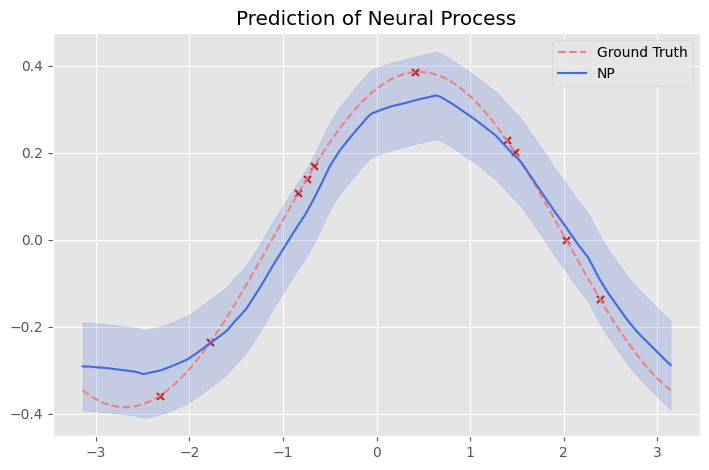

In [8]:
x_test, y_test, (amplitude, shift) = func.sample_data(num_tasks=1, num_samples=10)
x_grid = torch.linspace(-math.pi, math.pi, 1000)
y_grid = amplitude * torch.sin(x_grid - shift)
y_pred = model(x_test.to(dtype=dtype, device=device), y_test.to(dtype=dtype, device=device), x_grid.view(1, 1000, 1).to(dtype=dtype, device=device))

plt.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
plt.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

plt.plot(x_grid.detach().numpy(), y_pred.loc.cpu().detach().numpy().flatten(), color="royalblue", label="NP")
plt.fill_between(x_grid.detach().numpy(), y_pred.loc.cpu().detach().numpy().flatten() - y_pred.scale.cpu().detach().numpy().flatten(),
                                          y_pred.loc.cpu().detach().numpy().flatten() + y_pred.scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

plt.title("Prediction of Neural Process")
plt.legend()
plt.tight_layout()